<a href="https://colab.research.google.com/github/ayyucekizrak/Mechanistic-Interpretability/blob/main/qk_circuit_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Necessary Libraries**

In [1]:
# Install necessary libraries
!pip install transformer-lens circuitsvis matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

 **Import Necessary Libraries**

In [2]:
# Import necessary libraries
import torch as t
import numpy as np
from transformer_lens import HookedTransformer, ActivationCache
import matplotlib.pyplot as plt
import seaborn as sns


**Set Device to GPU if Available**


In [3]:
# Set device to GPU if available
device = t.device("cuda" if t.cuda.is_available() else "cpu")

**Load Pre-trained GPT-2 Model**

In [4]:
# Load a pre-trained GPT-2 model using TransformerLens
model = HookedTransformer.from_pretrained("gpt2-small").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


**Define Sample Input Sequences**

In [5]:
# Sample input sequences
sequences = [
    "the cat sat on the mat",
    "the cat sat the cat sat",
    "the quick brown fox jumps over the lazy dog",
    "the quick brown fox jumps the quick brown fox jumps"
]

**Tokenize Input Sequences**

In [6]:
# Tokenize sequences
tokenized_sequences = [model.to_tokens(seq).to(device) for seq in sequences]

**Function to Extract QK Patterns**

This function extracts the Query` (Q) `and Key` (K) `matrices from the attention layers of the transformer model for a specific layer.

In [7]:
def extract_qk_patterns(model, tokens, layer):
    # Get Query and Key matrices from the cache
    _, cache = model.run_with_cache(tokens)
    Q = cache[f'blocks.{layer}.attn.hook_q']
    K = cache[f'blocks.{layer}.attn.hook_k']
    return Q, K

**Extract QK Patterns for Each Sequence**

In [8]:
# Example: Extract QK patterns from layer 11
layer = 11
QK_patterns = [extract_qk_patterns(model, tokens, layer) for tokens in tokenized_sequences]

**Function to Plot QK Interactions**

In [9]:
def plot_qk_interactions(Q, K, tokens, title="QK Interaction Heatmap"):
    # Compute QK dot products for each head and then average
    QK_dot = t.einsum('bhqd,bhkd->bhqk', Q, K).mean(dim=0).mean(dim=0).cpu().numpy()

    # Visualize as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(QK_dot, annot=False, cmap='Blues', xticklabels=tokens, yticklabels=tokens)
    plt.title(title)
    plt.show()

**Visualize QK Interactions for Each Sequence**

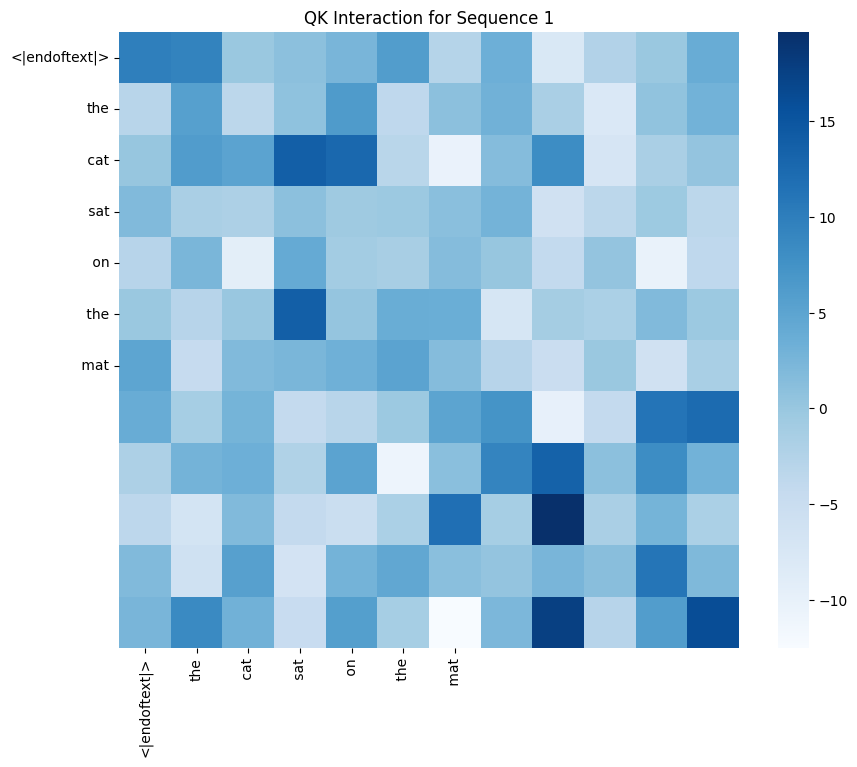

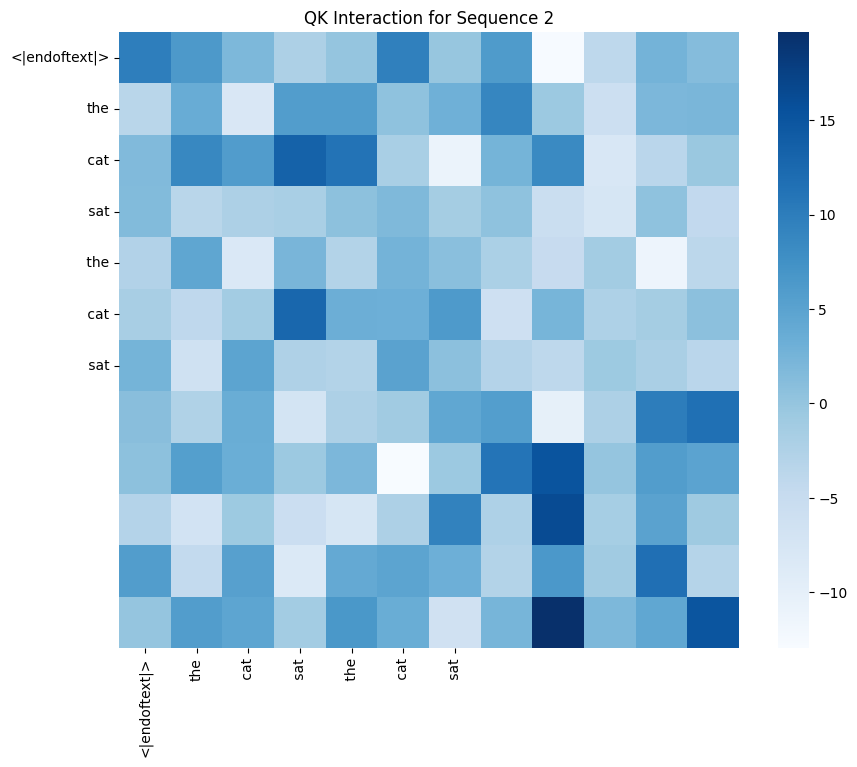

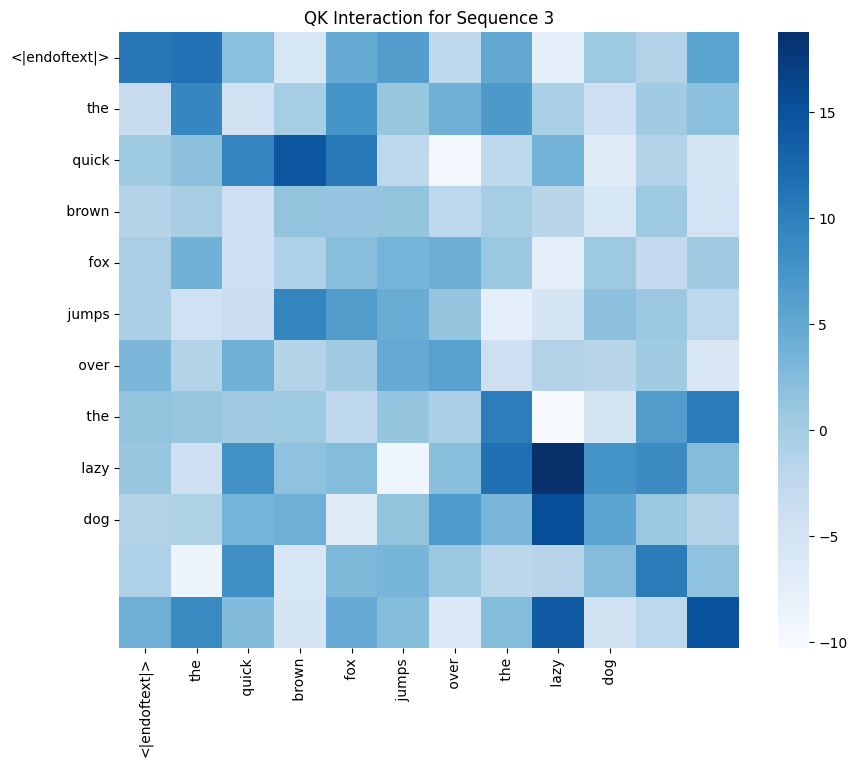

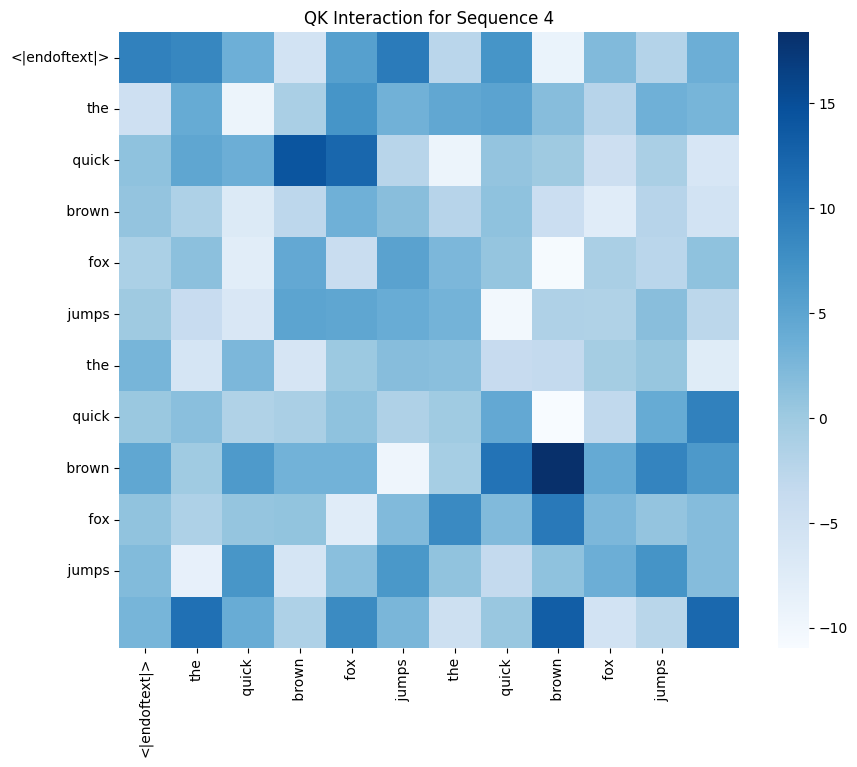

In [10]:
# Plot interactions for each sequence
for i, (Q, K) in enumerate(QK_patterns):
    tokens_str = model.to_str_tokens(tokenized_sequences[i])
    plot_qk_interactions(Q, K, tokens_str, title=f"QK Interaction for Sequence {i+1}")

### Updated Visualization for QK Circuit Analysis

*  **Interactive Heatmap:** This version uses Plotly to create an interactive heatmap where you can hover over each cell to see the values, and it provides a more intuitive visualization experience.
*  **Dynamic Range:** The visualization allows for dynamic scaling and zooming, making it easier to understand large matrices.
*  **Tooltips:** Tooltips show the exact attention scores between query and key tokens, enhancing the interpretability.


**Step-by-Step Usage:**

**1. Compute QK Dot Products:** The function computes the dot products between the Query and Key matrices for each head and averages them.

**2. Dimension Check:** It ensures that the QK interaction matrix matches the number of tokens in the input sequence.

**3. Interactive Heatmap:** Creates a heatmap visualization using Plotly.

In [11]:
!pip install transformer-lens plotly

In [12]:
import torch as t
import numpy as np
from transformer_lens import HookedTransformer, ActivationCache
import plotly.express as px
import matplotlib.pyplot as plt

# Set device to GPU if available
device = t.device("cuda" if t.cuda.is_available() else "cpu")


In [15]:
# Load a pre-trained GPT-2 model using TransformerLens
model = HookedTransformer.from_pretrained("gpt2-small").to(device)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


In [16]:
# Sample input sequences
sequences = [
    "the cat sat on the mat",
    "the cat sat the cat sat",
    "the quick brown fox jumps over the lazy dog",
    "the quick brown fox jumps the quick brown fox jumps"
]

# Tokenize sequences
tokenized_sequences = [model.to_tokens(seq).to(device) for seq in sequences]


In [17]:
def extract_qk_patterns(model, tokens, layer):
    _, cache = model.run_with_cache(tokens)
    Q = cache[f'blocks.{layer}.attn.hook_q']
    K = cache[f'blocks.{layer}.attn.hook_k']
    return Q, K

# Example: Extract QK patterns from layer 11
layer = 11
QK_patterns = [extract_qk_patterns(model, tokens, layer) for tokens in tokenized_sequences]


In [20]:
def plot_interactive_qk_heatmap(Q, K, tokens, title="QK Interaction Heatmap"):
    # Compute QK dot products for each head and then average
    QK_dot = t.einsum('bhqd,bhkd->bhqk', Q, K).mean(dim=0).cpu().numpy()

    # Get the number of tokens and heads
    num_tokens = len(tokens)
    num_heads = QK_dot.shape[0]

    # Check if dimensions match, if not, truncate or pad QK_dot
    if QK_dot.shape[1] != num_tokens:
        QK_dot = QK_dot[:, :num_tokens, :num_tokens]

    # Average over all heads
    QK_dot_mean = QK_dot.mean(axis=0)

    # Create a DataFrame for Plotly
    import pandas as pd
    df = pd.DataFrame(QK_dot_mean, index=tokens, columns=tokens)

    # Create interactive heatmap using Plotly
    fig = px.imshow(df, text_auto=True, aspect="auto", color_continuous_scale="Blues")
    fig.update_layout(title=title, xaxis_title="Key Tokens", yaxis_title="Query Tokens")
    fig.show()


In [23]:
# Plot interactions for each sequence
for i, (Q, K) in enumerate(QK_patterns):
    tokens_str = model.to_str_tokens(tokenized_sequences[i])
    plot_interactive_qk_heatmap(Q, K, tokens_str, title=f"QK Interaction for Sequence {i+1}")
